## Import Necessary Packages and Libraries

In [87]:
#import packages and libraries

import pandas as pd
import re
import html
import unicodedata
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import librosa
import librosa.display
from pydub.silence import split_on_silence
import numpy as np
from pydub import AudioSegment
from pydub.effects import normalize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import soundfile as sf
import math
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import json
from collections import Counter

## Merge Multiple Audio and Convert mp3 to wav

In [2]:
def merge_audio(file_paths, output_filename):
    combined = None
    for file_path in file_paths:
        print(f"Loading {file_path}...")
        audio = AudioSegment.from_file(file_path, format="mp3")
        if combined is None:
            combined = audio
        else:
            combined += audio  

    combined.export(output_filename, format="wav")
    print(f"Saved merged file as {output_filename}")


# Define file paths for each speaker
choi_files = [
    "/Users/seojin/Downloads/Choi1.mp3",
    "/Users/seojin/Downloads/Choi2.mp3",
    "/Users/seojin/Downloads/Choi3.mp3",
    "/Users/seojin/Downloads/Choi4.mp3"
    
]
hun_files = [
    "/Users/seojin/Downloads/Hun1.mp3",
    "/Users/seojin/Downloads/Hun2.mp3",
    "/Users/seojin/Downloads/Hun3.mp3",
    "/Users/seojin/Downloads/Hun4.mp3"
]

# Merge and convert for each speaker
merge_audio(choi_files, "Choi.wav")
merge_audio(hun_files, "Hun.wav")


Loading /Users/seojin/Downloads/Choi1.mp3...
Loading /Users/seojin/Downloads/Choi2.mp3...
Loading /Users/seojin/Downloads/Choi3.mp3...
Loading /Users/seojin/Downloads/Choi4.mp3...
Saved merged file as Choi.wav
Loading /Users/seojin/Downloads/Hun1.mp3...
Loading /Users/seojin/Downloads/Hun2.mp3...
Loading /Users/seojin/Downloads/Hun3.mp3...
Loading /Users/seojin/Downloads/Hun4.mp3...
Saved merged file as Hun.wav


## Preprocess Data (mono / normalize / silence removal)

In [3]:
def preprocess_audio(filepath, save_as=None, target_sr=16000, return_intermediate=False):
    # Load audio in mono
    audio, sr = librosa.load(filepath, sr=None, mono=True)

    # Resample
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    # Normalize to [-1, 1]
    audio = audio / np.max(np.abs(audio))
    original_audio = audio.copy()

    # Convert to 16-bit PCM for pydub
    audio_pcm = (audio * 32767).astype(np.int16)
    segment = AudioSegment(
        audio_pcm.tobytes(),
        frame_rate=sr,
        sample_width=2,
        channels=1
    )

    # Silence removal
    chunks = split_on_silence(segment, min_silence_len=500, silence_thresh=-40)
    if chunks:
        processed_segment = sum(chunks)
    else:
        processed_segment = segment  # Keep the original if silence removal fails

    # Convert back to float numpy array
    processed_audio = np.array(processed_segment.get_array_of_samples()).astype(np.float32)
    processed_audio /= 32767

    # Save processed audio if needed
    if save_as:
        sf.write(save_as, processed_audio, sr)

    if return_intermediate:
        return original_audio, processed_audio, sr
    else:
        return processed_audio, sr


## Exploratory Data Analysis (EDA)

In [5]:
# Run preprocessing and keep both original and silence-removed audio
original, processed, sr = preprocess_audio("Choi.wav", save_as="Choi_processed.wav", return_intermediate=True)

original_2, processed_2, sr_2 = preprocess_audio("Hun.wav", save_as="Hun_processed.wav", return_intermediate=True)


In [6]:
def get_rms_stats(audio, sr, label="Speaker"):
    rms = librosa.feature.rms(y=audio)[0]

    stats = {
        "Speaker": label,
        "Mean RMS": np.mean(rms),
        "Median RMS": np.median(rms),
        "Std Dev": np.std(rms),
        "Min RMS": np.min(rms),
        "Max RMS": np.max(rms),
        "Skewness": (np.mean((rms - np.mean(rms))**3)) / (np.std(rms)**3 + 1e-6)
    }

    return stats

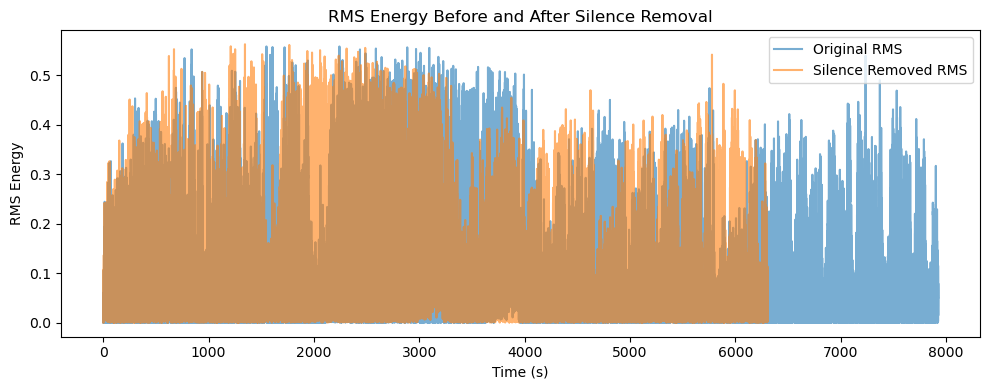

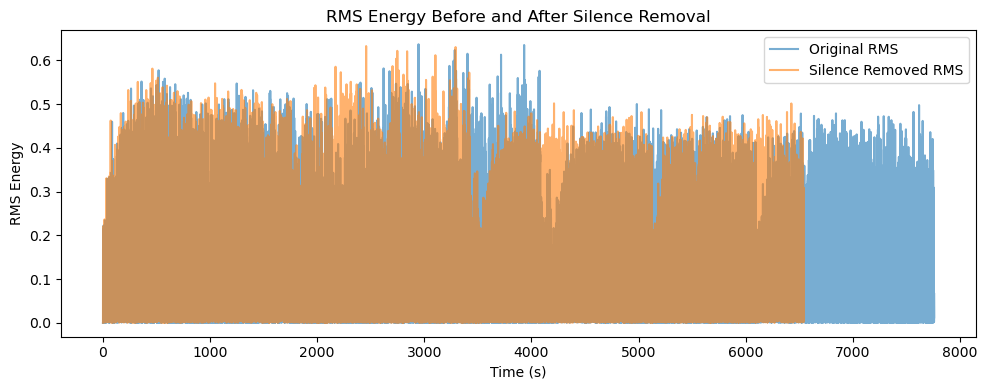

In [7]:
def compare_rms(original_audio, processed_audio, sr):
    hop = 512
    rms1 = librosa.feature.rms(y=original_audio, hop_length=hop)[0]
    rms2 = librosa.feature.rms(y=processed_audio, hop_length=hop)[0]
    t1 = librosa.frames_to_time(np.arange(len(rms1)), sr=sr, hop_length=hop)
    t2 = librosa.frames_to_time(np.arange(len(rms2)), sr=sr, hop_length=hop)

    plt.figure(figsize=(10, 4))
    plt.plot(t1, rms1, label='Original RMS', alpha=0.6)
    plt.plot(t2, rms2, label='Silence Removed RMS', alpha=0.6)
    plt.xlabel('Time (s)')
    plt.ylabel('RMS Energy')
    plt.title('RMS Energy Before and After Silence Removal')
    plt.legend()
    plt.tight_layout()
    plt.show()

compare_rms(original, processed, sr)
compare_rms(original_2, processed_2, sr_2)

In [8]:
def plot_waveform_comparison(file1, file2, label1='Speaker 1', label2='Speaker 2', duration=1.0):
    # Load both files (mono + normalized already)
    y1, sr1 = librosa.load(file1, sr=16000, mono=True, duration=duration)
    y2, sr2 = librosa.load(file2, sr=16000, mono=True, duration=duration)

    # Create time axes
    t1 = np.linspace(0, duration, len(y1))
    t2 = np.linspace(0, duration, len(y2))

    # Plot both waveforms
    plt.figure(figsize=(10, 4))
    plt.plot(t1, y1, label=label1, alpha=0.7)
    plt.plot(t2, y2, label=label2, alpha=0.7)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Waveform Comparison: {label1} vs {label2} (First {duration} second)")
    plt.legend()
    plt.tight_layout()
    plt.show()

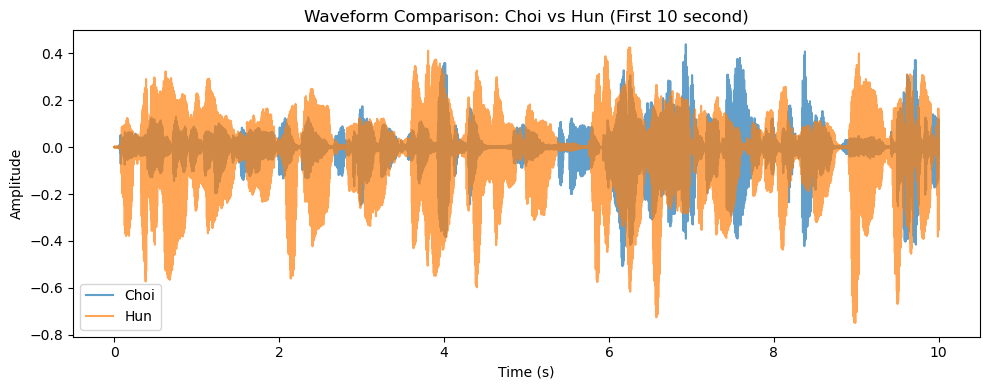

In [9]:
plot_waveform_comparison("Choi_processed.wav", "Hun_processed.wav", label1='Choi', label2='Hun', duration=10)

In [10]:
def plot_zcr_comparison(audio1, audio2, sr, label1="Speaker 1", label2="Speaker 2", duration=10):
    hop_length = 512

    # Trim both audios to the specified duration (in samples)
    max_samples = int(duration * sr)
    audio1 = audio1[:max_samples]
    audio2 = audio2[:max_samples]

    # Compute ZCR
    zcr1 = librosa.feature.zero_crossing_rate(y=audio1, hop_length=hop_length)[0]
    zcr2 = librosa.feature.zero_crossing_rate(y=audio2, hop_length=hop_length)[0]

    # Compute time axes
    times1 = librosa.frames_to_time(np.arange(len(zcr1)), sr=sr, hop_length=hop_length)
    times2 = librosa.frames_to_time(np.arange(len(zcr2)), sr=sr, hop_length=hop_length)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(times1, zcr1, label=label1, alpha=0.7)
    plt.plot(times2, zcr2, label=label2, alpha=0.7)
    plt.xlabel("Time (s)")
    plt.ylabel("Zero-Crossing Rate")
    plt.title(f"ZCR Comparison ({duration} Seconds)")
    plt.legend()
    plt.tight_layout()
    plt.show()


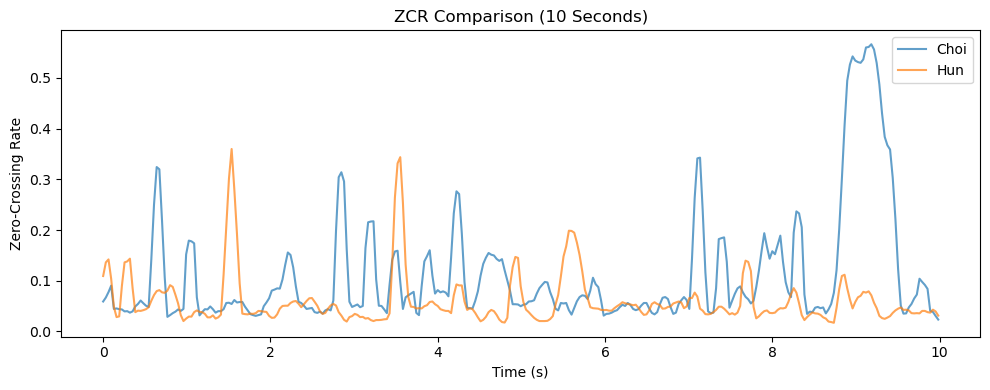

In [11]:
plot_zcr_comparison(processed, processed_2, sr, label1="Choi", label2="Hun")

In [12]:
def compare_pitch(audio1, audio2, sr, label1='Speaker 1', label2='Speaker 2', duration=10):
    # Calculate number of samples for the given duration
    n_samples = int(duration * sr)

    # Clip audio to desired duration
    audio1_clip = audio1[:n_samples]
    audio2_clip = audio2[:n_samples]

    # Estimate pitch
    f0_1 = librosa.yin(audio1_clip, fmin=50, fmax=500, sr=sr)
    f0_2 = librosa.yin(audio2_clip, fmin=50, fmax=500, sr=sr)

    t1 = librosa.times_like(f0_1, sr=sr)
    t2 = librosa.times_like(f0_2, sr=sr)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(t1, f0_1, label=label1, alpha=0.7)
    plt.plot(t2, f0_2, label=label2, alpha=0.7)
    plt.xlabel("Time (s)")
    plt.ylabel("Fundamental Frequency (Hz)")
    plt.title(f"Pitch Contour Comparison (First {duration:.1f}s)")
    plt.legend()
    plt.tight_layout()
    plt.show()


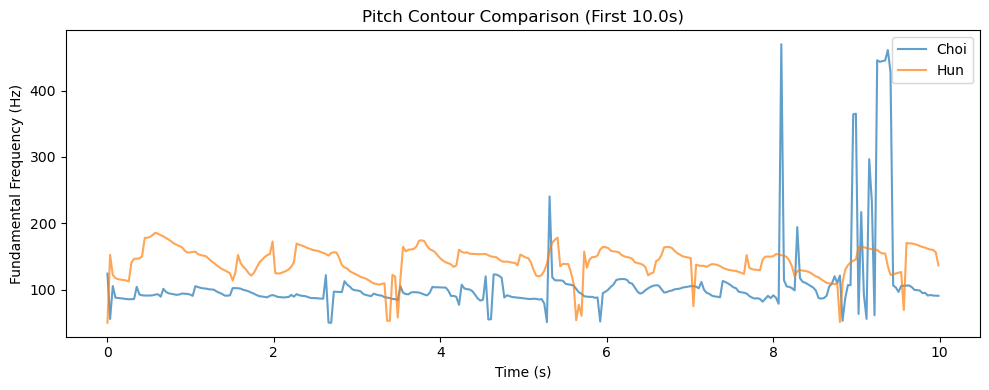

In [13]:
compare_pitch(processed, processed_2, sr, label1="Choi", label2="Hun")


In [14]:
def plot_rms_distribution(audio, sr, label="Speaker"):
    rms = librosa.feature.rms(y=audio)[0]
    plt.figure(figsize=(6, 4))
    plt.hist(rms, bins=50, alpha=0.8, color='skyblue')
    plt.xlabel("RMS Energy")
    plt.ylabel("Frequency")
    plt.title(f"RMS Energy Distribution - {label}")
    plt.tight_layout()
    plt.show()

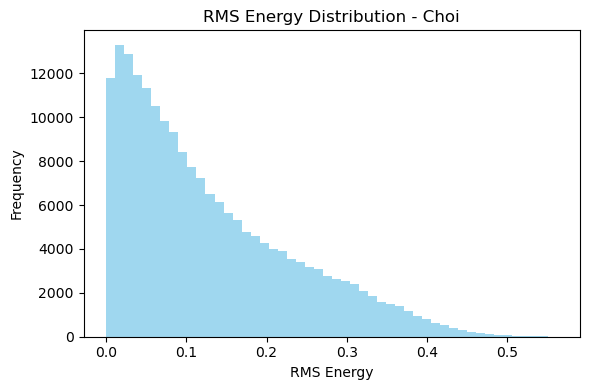

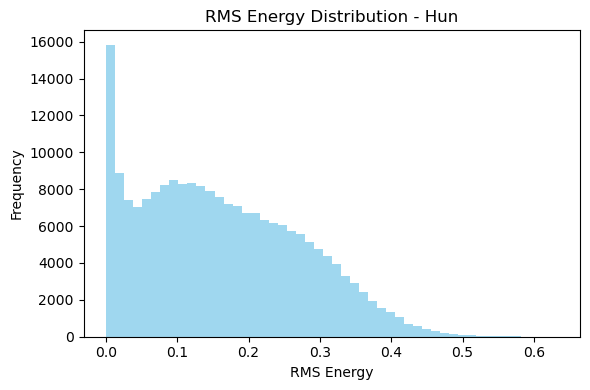

In [15]:
plot_rms_distribution(processed, sr, label="Choi")
plot_rms_distribution(processed_2, sr, label="Hun")

In [16]:
def summarize_audio_stats(audio, sr, label='Speaker'):
    import librosa
    import numpy as np

    duration = len(audio) / sr

    # RMS
    rms = librosa.feature.rms(y=audio)[0]
    rms_mean = np.mean(rms)
    rms_std = np.std(rms)

    # ZCR
    zcr = librosa.feature.zero_crossing_rate(y=audio)[0]
    zcr_mean = np.mean(zcr)
    zcr_std = np.std(zcr)

    # Pitch
    try:
        f0 = librosa.yin(audio, fmin=50, fmax=500, sr=sr)
        f0_mean = np.mean(f0[np.isfinite(f0)])
        f0_std = np.std(f0[np.isfinite(f0)])
    except:
        f0_mean, f0_std = None, None

    # Pack into a dictionary
    return {
        'Speaker': label,
        'Duration (s)': round(duration, 2),
        'RMS Mean': round(rms_mean, 4),
        'RMS Std': round(rms_std, 4),
        'ZCR Mean': round(zcr_mean, 4),
        'ZCR Std': round(zcr_std, 4),
        'Pitch Mean (Hz)': round(f0_mean, 2) if f0_mean else None,
        'Pitch Std (Hz)': round(f0_std, 2) if f0_std else None
    }


In [17]:
summary_choi = summarize_audio_stats(processed, sr, label='Choi')
summary_hun = summarize_audio_stats(processed_2, sr, label='Hun')

df = pd.DataFrame([summary_choi, summary_hun])
print(df)

  Speaker  Duration (s)  RMS Mean  RMS Std  ZCR Mean  ZCR Std  \
0    Choi       6305.51    0.1293   0.1046    0.0885   0.0767   
1     Hun       6544.88    0.1630   0.1111    0.0854   0.0675   

   Pitch Mean (Hz)  Pitch Std (Hz)  
0           161.65           61.54  
1           185.04           62.68  


## Feature Extraction for Random Forest Classifier & XGBoost

In [98]:
def features_for_baseline(audio, sr):
    features = {}

    # Duration
    duration = len(audio) / sr
    features['duration'] = duration

    # RMS Energy
    rms = librosa.feature.rms(y=audio)[0]
    features['rms_mean'] = np.mean(rms)
    features['rms_std'] = np.std(rms)

    # Zero-Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y=audio)[0]
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)

    # Pitch (Fundamental Frequency)
    try:
        f0 = librosa.yin(audio, fmin=50, fmax=500, sr=sr)
        f0 = f0[np.isfinite(f0)]
        features['f0_mean'] = np.mean(f0)
        features['f0_std'] = np.std(f0)
    except:
        features['f0_mean'] = 0
        features['f0_std'] = 0

    # MFCCs
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc{i+1}_mean'] = np.mean(mfcc[i])
        features[f'mfcc{i+1}_std'] = np.std(mfcc[i])

    # Chroma
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    for i in range(12):
        features[f'chroma{i+1}_mean'] = np.mean(chroma[i])
        features[f'chroma{i+1}_std'] = np.std(chroma[i])

    # Spectral features
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    flatness = librosa.feature.spectral_flatness(y=audio)[0]
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]

    features['centroid_mean'] = np.mean(centroid)
    features['centroid_std'] = np.std(centroid)

    features['bandwidth_mean'] = np.mean(bandwidth)
    features['bandwidth_std'] = np.std(bandwidth)

    features['flatness_mean'] = np.mean(flatness)
    features['flatness_std'] = np.std(flatness)

    features['rolloff_mean'] = np.mean(rolloff)
    features['rolloff_std'] = np.std(rolloff)

    # Convert dict to 1D numpy array
    feature_vector = np.array(list(features.values()), dtype=np.float32)

    return feature_vector, list(features.keys())  # return names too if you want to track features


In [100]:
def split_audio(audio, sr, chunk_duration=1.0):
    chunk_size = int(chunk_duration * sr)
    chunks = []

    for start in range(0, len(audio) - chunk_size + 1, chunk_size):
        chunk = audio[start:start + chunk_size]
        chunks.append(chunk)

    return chunks


In [104]:
def extract_dataset_baseline(choi_audio, hun_audio, sr):
    # 1. Split into non-overlapping chunks
    choi_chunks = split_audio(choi_audio, sr)
    hun_chunks = split_audio(hun_audio, sr)

    # 2. Extract features from each chunk
    choi_vecs = [features_for_baseline(chunk, sr)[0] for chunk in choi_chunks]
    hun_vecs = [features_for_baseline(chunk, sr)[0] for chunk in hun_chunks]

    # 3. Stack features and create labels
    X = np.vstack([choi_vecs, hun_vecs])
    y = np.concatenate([
        np.zeros(len(choi_vecs)),  # label 0 = Choi
        np.ones(len(hun_vecs))     # label 1 = Hun
    ])

    return X, y


In [106]:
X_baseline, y_baseline = extract_dataset_baseline(processed, processed_2, sr)

print("Feature matrix shape:", X_baseline.shape)
print("Label vector shape:", y_baseline.shape)

# Optional: train/test split
from sklearn.model_selection import train_test_split

X_baseline_train, X_baseline_test, y_baseline_train, y_baseline_test = train_test_split(
    X_baseline, y_baseline, test_size=0.2, stratify=y_baseline, random_state=42
)


Feature matrix shape: (12849, 65)
Label vector shape: (12849,)


In [107]:
#train/test split

X_baseline = np.vstack([choi_features, hun_features])
y_baseline = np.concatenate([
    np.zeros(len(choi_features)),
    np.ones(len(hun_features))
])

from sklearn.model_selection import train_test_split

X_baseline_train, X_baseline_test, y_baseline_train, y_baseline_test = train_test_split(
    X_baseline, y_baseline, test_size=0.2, stratify=y_baseline, random_state=42
)

## Random Forest Classifier

In [108]:
class TreeNode:
    def __init__(self, feat_index=None, thresh_val=None, left_child=None, right_child=None, *, label=None):
        """
        A node in the decision tree.
        
        Args:
            feat_index (int): The index of the feature to split on.
            thresh_val (float): The threshold value for splitting.
            left_child (TreeNode): Left subtree.
            right_child (TreeNode): Right subtree.
            label (int, optional): Label if the node is a leaf.
        """
        self.feat_index = feat_index
        self.thresh_val = thresh_val
        self.left_child = left_child
        self.right_child = right_child
        self.label = label

    def is_leaf(self):
        """Return True if the node is a leaf node."""
        return self.label is not None

class CustomTree:
    def __init__(self, min_split_count=2, max_depth=100, num_features=None):
        """
        Decision tree initializer.
        
        Args:
            min_split_count (int): Minimum number of samples required to attempt a split.
            max_depth (int): Maximum depth of the tree.
            num_features (int, optional): Number of features to consider for a split.
        """
        self.min_split_count = min_split_count
        self.max_depth = max_depth
        self.num_features = num_features
        self.root_node = None

    def fit(self, data, targets):
        """
        Build the decision tree from the training data.
        
        Args:
            data (np.array): Feature matrix.
            targets (np.array): Target labels.
        """
        self.num_features = data.shape[1] if not self.num_features else min(data.shape[1], self.num_features)
        self.root_node = self._build_tree(data, targets)

    def _build_tree(self, data, targets, depth=0):
        sample_count, feature_count = data.shape
        unique_labels = len(np.unique(targets))

        # Stopping criteria: maximum depth reached, pure node, or insufficient samples
        if depth >= self.max_depth or unique_labels == 1 or sample_count < self.min_split_count:
            final_label = self._most_frequent_label(targets)
            return TreeNode(label=final_label)

        # Randomly select features to consider for splitting
        chosen_features = np.random.choice(feature_count, self.num_features, replace=False)
        best_feat, best_thresh = self._find_optimal_split(data, targets, chosen_features)

        # Partition the data based on the best feature and threshold
        left_idxs, right_idxs = self._partition(data[:, best_feat], best_thresh)
        left_branch = self._build_tree(data[left_idxs, :], targets[left_idxs], depth + 1)
        right_branch = self._build_tree(data[right_idxs, :], targets[right_idxs], depth + 1)
        return TreeNode(best_feat, best_thresh, left_branch, right_branch)

    def _find_optimal_split(self, data, targets, feature_indices):
        """
        Determine the best feature and threshold to split the data.
        
        Args:
            data (np.array): Feature matrix.
            targets (np.array): Target labels.
            feature_indices (np.array): Indices of features to consider.
        
        Returns:
            Tuple[int, float]: The best feature index and threshold value.
        """
        optimal_gain = -1
        best_feature = None
        best_threshold = None
        for index in feature_indices:
            column_data = data[:, index]
            possible_thresholds = np.unique(column_data)
            for threshold in possible_thresholds:
                gain = self._calc_info_gain(targets, column_data, threshold)
                if gain > optimal_gain:
                    optimal_gain = gain
                    best_feature = index
                    best_threshold = threshold
        return best_feature, best_threshold

    def _calc_info_gain(self, targets, column_data, threshold):
        """
        Calculate information gain for a potential split.
        
        Args:
            targets (np.array): Target labels.
            column_data (np.array): Data for the chosen feature.
            threshold (float): Threshold to split on.
        
        Returns:
            float: The information gain from the split.
        """
        parent_entropy = self._compute_entropy(targets)
        left_idxs, right_idxs = self._partition(column_data, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        total_samples = len(targets)
        count_left, count_right = len(left_idxs), len(right_idxs)
        entropy_left = self._compute_entropy(targets[left_idxs])
        entropy_right = self._compute_entropy(targets[right_idxs])
        weighted_entropy = (count_left / total_samples) * entropy_left + (count_right / total_samples) * entropy_right

        return parent_entropy - weighted_entropy

    def _partition(self, column_data, threshold):
        """
        Partition data indices based on a threshold.
        
        Args:
            column_data (np.array): Data for a feature.
            threshold (float): Threshold value.
        
        Returns:
            Tuple[np.array, np.array]: Indices for left and right splits.
        """
        left_idxs = np.argwhere(column_data <= threshold).flatten()
        right_idxs = np.argwhere(column_data > threshold).flatten()
        return left_idxs, right_idxs

    def _compute_entropy(self, targets):
        """
        Compute entropy of a label distribution.
        
        Args:
            targets (np.array): Target labels.
        
        Returns:
            float: Entropy value.
        """
        counts = np.bincount(targets)
        probabilities = counts / len(targets)
        return -np.sum([p * np.log(p) for p in probabilities if p > 0])

    def _most_frequent_label(self, targets):
        """
        Determine the most frequent label in the targets.
        
        Args:
            targets (np.array): Target labels.
        
        Returns:
            int: The most common label.
        """
        label_counter = Counter(targets)
        return label_counter.most_common(1)[0][0]

    def predict(self, data):
        """
        Predict labels for given data samples.
        
        Args:
            data (np.array): Feature matrix.
        
        Returns:
            np.array: Predicted labels.
        """
        return np.array([self._traverse_tree(sample, self.root_node) for sample in data])

    def _traverse_tree(self, sample, node):
        """
        Recursively traverse the tree to obtain a prediction for a single sample.
        
        Args:
            sample (np.array): A single data sample.
            node (TreeNode): Current node in the tree.
        
        Returns:
            int: Predicted label.
        """
        if node.is_leaf():
            return node.label
        if sample[node.feat_index] <= node.thresh_val:
            return self._traverse_tree(sample, node.left_child)
        return self._traverse_tree(sample, node.right_child)



In [126]:
class EnsembleForest:
    def __init__(self, num_trees=10, tree_depth=10, min_split_count=2, num_features=None, random_state=None):
        """
        Initialize the ensemble of decision trees.

        Args:
            num_trees (int): Number of trees in the forest.
            tree_depth (int): Maximum depth for each tree.
            min_split_count (int): Minimum samples required to split a node.
            num_features (int, optional): Number of features to consider when splitting.
        """
        self.num_trees = num_trees
        self.tree_depth = tree_depth
        self.min_split_count = min_split_count
        self.num_features = num_features
        self.forest = []

    def fit(self, data, targets):
        """
        Build the forest by training multiple trees on bootstrap samples.
        
        Args:
            data (np.array): Feature matrix.
            targets (np.array): Target labels.
        """
        self.forest = []
        for _ in range(self.num_trees):
            tree_instance = CustomTree(max_depth=self.tree_depth,
                                       min_split_count=self.min_split_count,
                                       num_features=self.num_features)
            boot_data, boot_targets = self._bootstrap_sample(data, targets)
            tree_instance.fit(boot_data, boot_targets)
            self.forest.append(tree_instance)

    def _bootstrap_sample(self, data, targets):
        """
        Create a bootstrap sample of the data.
        
        Args:
            data (np.array): Feature matrix.
            targets (np.array): Target labels.
        
        Returns:
            Tuple[np.array, np.array]: Bootstrapped data and targets.
        """
        sample_count = data.shape[0]
        indices = np.random.choice(sample_count, sample_count, replace=True)
        return data[indices], targets[indices]

    def _most_frequent_prediction(self, predictions):
        """
        Aggregate predictions from multiple trees using majority vote.
        
        Args:
            predictions (list): List of predictions from each tree.
        
        Returns:
            int: Majority voted prediction.
        """
        counter = Counter(predictions)
        return counter.most_common(1)[0][0]

    def predict(self, data):
        """
        Predict labels for each sample by aggregating predictions from all trees.
        
        Args:
            data (np.array): Feature matrix.
        
        Returns:
            np.array: Final predicted labels.
        """
        all_tree_preds = np.array([tree.predict(data) for tree in self.forest])
        sample_preds = np.swapaxes(all_tree_preds, 0, 1)
        final_preds = np.array([self._most_frequent_prediction(row) for row in sample_preds])
        return final_preds

In [112]:
y_baseline_train = y_baseline_train.astype(int)
y_baseline_test = y_baseline_test.astype(int)

# Train and evaluate your custom forest
my_forest = EnsembleForest(num_trees=10, tree_depth=10)
my_forest.fit(X_baseline_train, y_baseline_train)
y_pred = my_forest.predict(X_baseline_test)

print(f"✅ Accuracy: {accuracy_score(y_baseline_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_baseline_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_baseline_test, y_pred))


✅ Accuracy: 0.8261
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1261
           1       0.80      0.87      0.84      1309

    accuracy                           0.83      2570
   macro avg       0.83      0.83      0.83      2570
weighted avg       0.83      0.83      0.83      2570

Confusion Matrix:
 [[ 984  277]
 [ 170 1139]]


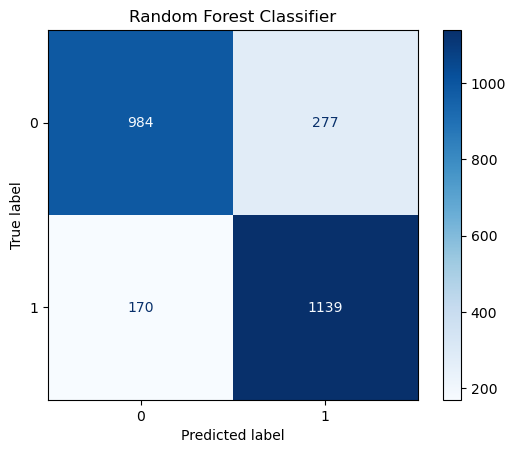

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix values for the first model
cm1 = np.array([[984, 277],
                [170, 1139]])

# Display the confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Classifier")
plt.show()


## XGBoost

In [120]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1. Define the model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

# 2. Train
xgb_model.fit(X_baseline_train, y_baseline_train)

# 3. Predict
y_pred = xgb_model.predict(X_baseline_test)

# 4. Evaluate
acc = accuracy_score(y_baseline_test, y_pred)
print(f"✅ XGBoost Accuracy: {acc:.4f}\n")


print("Classification Report:\n", classification_report(y_baseline_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_baseline_test, y_pred))


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:24:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost Accuracy: 0.8813

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      1261
           1       0.87      0.90      0.89      1309

    accuracy                           0.88      2570
   macro avg       0.88      0.88      0.88      2570
weighted avg       0.88      0.88      0.88      2570

Confusion Matrix:
 [[1091  170]
 [ 135 1174]]


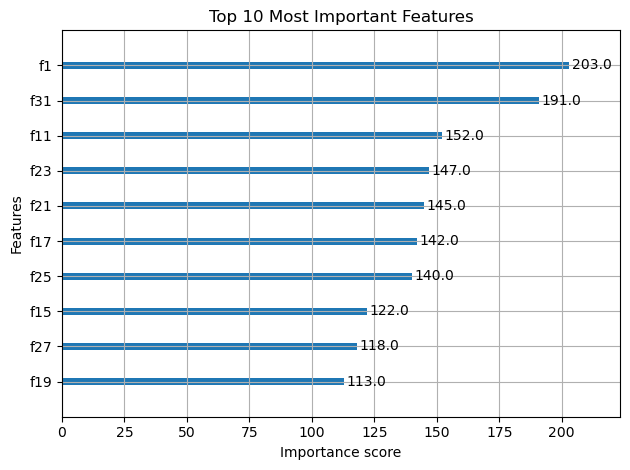

In [122]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.title("Top 10 Most Important Features")
plt.tight_layout()
plt.show()


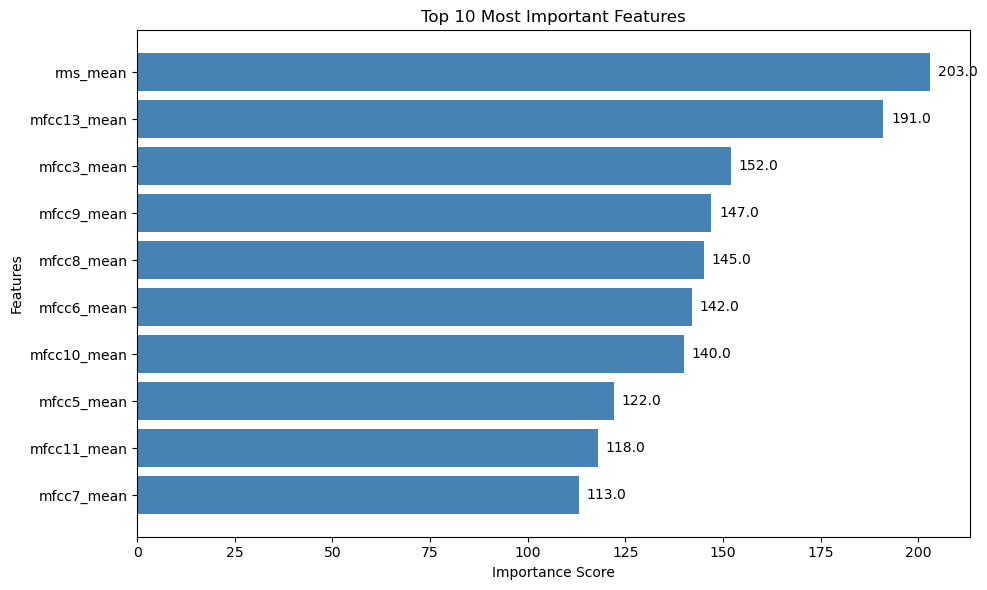

In [203]:
import matplotlib.pyplot as plt

# Top 10 feature indices and their importance scores (manually extracted from the image)
top_features = {
    1: 203.0,
    31: 191.0,
    11: 152.0,
    23: 147.0,
    21: 145.0,
    17: 142.0,
    25: 140.0,
    15: 122.0,
    27: 118.0,
    19: 113.0
}

# Feature index to name mapping (based on the order in features_for_baseline)
feature_names = [
    'duration', 'rms_mean', 'rms_std', 'zcr_mean', 'zcr_std', 'f0_mean', 'f0_std'
]
# MFCCs
for i in range(13):
    feature_names.append(f'mfcc{i+1}_mean')
    feature_names.append(f'mfcc{i+1}_std')
# Chroma
for i in range(12):
    feature_names.append(f'chroma{i+1}_mean')
    feature_names.append(f'chroma{i+1}_std')
# Spectral features
feature_names += [
    'centroid_mean', 'centroid_std',
    'bandwidth_mean', 'bandwidth_std',
    'flatness_mean', 'flatness_std',
    'rolloff_mean', 'rolloff_std'
]

# Map feature indices to names
named_features = {feature_names[idx]: score for idx, score in top_features.items()}

# Sort by importance
sorted_named = dict(sorted(named_features.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(list(sorted_named.keys())[::-1], list(sorted_named.values())[::-1], color='steelblue')
for i, (feature, score) in enumerate(reversed(sorted_named.items())):
    plt.text(score + 2, i, f'{score:.1f}', va='center')

plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()


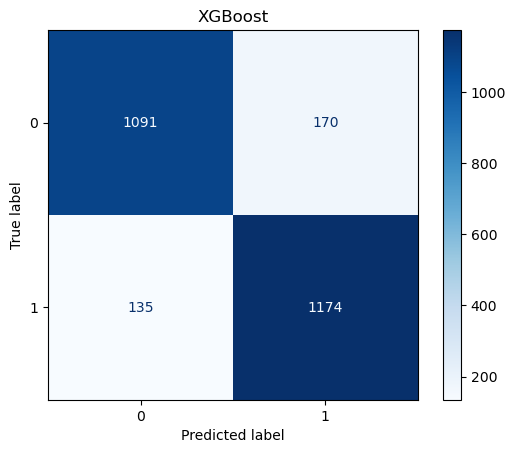

In [195]:
# Confusion matrix values for the second model
cm2 = np.array([[1091, 170],
                [135, 1174]])

# Display the confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2)
disp2.plot(cmap=plt.cm.Blues)
plt.title("XGBoost")
plt.show()

## Convolutional Neural Network (CNN)

### Create Mel Spectrogram

In [22]:
# Parameters
SAMPLE_RATE = 16000    
CHUNK_DURATION = 4     
CHUNK_SIZE = int(CHUNK_DURATION * SAMPLE_RATE)
STEP_SIZE = CHUNK_SIZE  
N_FFT = 400
HOP_LENGTH = 160
N_MELS = 64
FMIN = 50
FMAX = 8000


In [23]:
# Non-overlapping chunking
def split_audio(audio, chunk_size=CHUNK_SIZE, step_size=STEP_SIZE):
    chunks = []
    for start in range(0, len(audio) - chunk_size + 1, step_size):
        chunk = audio[start:start + chunk_size]
        chunks.append(chunk)
    return chunks


In [24]:
# Mel spectrogram extraction
def extract_mel_spectrogram(chunk, sr=SAMPLE_RATE):
    mel = librosa.feature.melspectrogram(
        y=chunk,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=N_MELS,
        fmin=FMIN,
        fmax=FMAX
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    return mel_db  # shape: (n_mels, time_frames)


In [25]:
# Full dataset creation
def create_mel_dataset(audio, sr=SAMPLE_RATE):
    chunks = split_audio(audio)
    mel_specs = [extract_mel_spectrogram(chunk, sr) for chunk in chunks]
    return np.array(mel_specs)  # shape: (n_chunks, n_mels, time_frames)


In [26]:
mel_choi = create_mel_dataset(processed, sr)
mel_hun = create_mel_dataset(processed_2, sr)

print("Choi Mel shape:", mel_choi.shape)  # → (n_chunks, 64, ~100)
print("Hun Mel shape:", mel_hun.shape)


Choi Mel shape: (1576, 64, 401)
Hun Mel shape: (1636, 64, 401)


In [27]:
print(f"Number of Choi samples: {len(mel_choi)}")
print(f"Number of Hun samples: {len(mel_hun)}")


Number of Choi samples: 1576
Number of Hun samples: 1636


In [28]:
def show_mel_spectrogram(mel_spectrogram, sr=SAMPLE_RATE, title='Mel Spectrogram'):
    plt.figure(figsize=(8, 4))
    librosa.display.specshow(
        mel_spectrogram,
        sr=sr,
        hop_length=HOP_LENGTH,
        x_axis='time',
        y_axis='mel',
        fmin=FMIN,
        fmax=FMAX
    )
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()


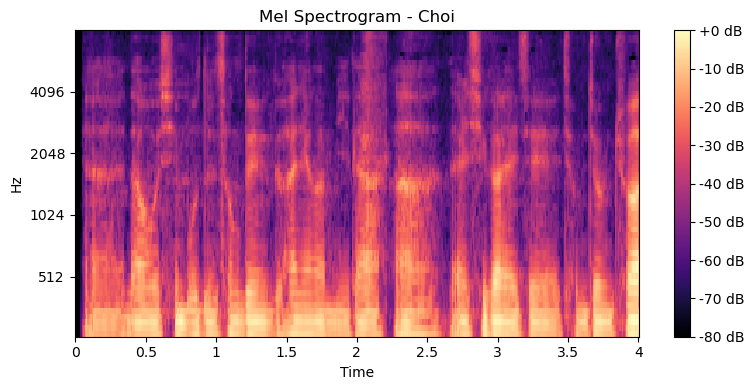

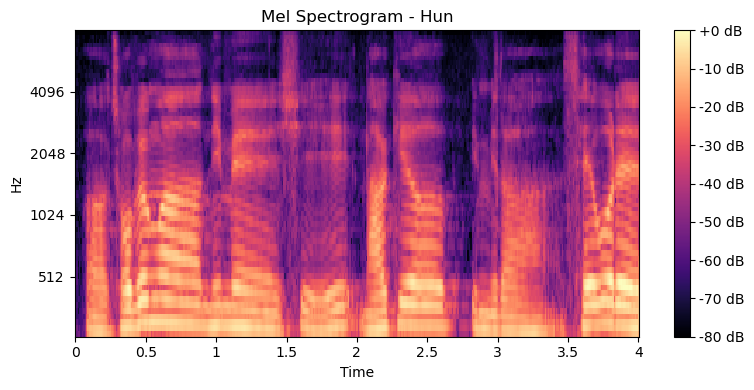

In [29]:
# Show the first Mel spectrogram from Choi
show_mel_spectrogram(mel_choi[0], title="Mel Spectrogram - Choi")

# Show the first Mel spectrogram from Hun
show_mel_spectrogram(mel_hun[0], title="Mel Spectrogram - Hun")


In [30]:
# Labels
labels_choi = np.zeros(len(mel_choi))   # label 0 for Choi
labels_hun = np.ones(len(mel_hun))      # label 1 for Hun

# Combine features and labels
X = np.concatenate([mel_choi, mel_hun], axis=0)           # shape: (n_samples, n_mels, time)
y = np.concatenate([labels_choi, labels_hun], axis=0)     # shape: (n_samples,)


### Split Dataset (Train/Test)

In [221]:
# CNN data and labels
X_cnn = np.concatenate([mel_choi, mel_hun], axis=0)
y_cnn = np.concatenate([
    np.zeros(len(mel_choi)),  # label 0 for Choi
    np.ones(len(mel_hun))     # label 1 for Hun
])

# Add channel dimension
X_cnn = X_cnn[..., np.newaxis]  # shape: (n_samples, 64, time, 1)

# Split
X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(
    X_cnn, y_cnn, test_size=0.2, stratify=y_cnn, random_state=42
)


### CNN Model (with 4 blocks)

In [231]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

def build_cnn_model(input_shape, num_classes=1):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten and Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(
        64,  # Slightly reduced from 128
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)  # L2 Regularization added
    ))
    model.add(layers.Dropout(0.5))  # Increased Dropout

    # Output layer
    if num_classes == 1:
        model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification
    else:
        model.add(layers.Dense(num_classes, activation='softmax'))  # Multi-class

    return model

In [225]:
# Assuming input Mel spectrogram shape = (n_mels, time, 1)
input_shape = X_cnn_train.shape[1:]  # e.g. (64, 100, 1)

model = build_cnn_model(input_shape=input_shape, num_classes=1)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # use 'categorical_crossentropy' for multi-class
    metrics=['accuracy']
)

model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 401, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 401, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 200, 16)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 200, 32)    │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 200, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 100, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 100, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 50, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 50, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 50, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 25, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,736,769 (6.63 MB)

 Trainable params: 1,736,289 (6.62 MB)

 Non-trainable params: 480 (1.88 KB)

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. Define the model
rf_model = RandomForestClassifier(
    n_estimators=100,     # number of trees
    max_depth=None,       # let trees grow fully
    random_state=42
)

# 2. Train
rf_model.fit(X_xgb_train, y_xgb_train)

# 3. Predict
y_rf_pred = rf_model.predict(X_xgb_test)

# 4. Evaluate
acc = accuracy_score(y_xgb_test, y_rf_pred)
print(f"✅ Random Forest Accuracy: {acc:.4f}\n")

print("Classification Report:\n", classification_report(y_xgb_test, y_rf_pred))
print("Confusion Matrix:\n", confusion_matrix(y_xgb_test, y_rf_pred))


✅ Random Forest Accuracy: 0.8409

Classification Report:
               precision    recall  f1-score   support

         0.0       0.86      0.81      0.83      1261
         1.0       0.83      0.87      0.85      1309

    accuracy                           0.84      2570
   macro avg       0.84      0.84      0.84      2570
weighted avg       0.84      0.84      0.84      2570

Confusion Matrix:
 [[1023  238]
 [ 171 1138]]


## Training CNN and Hyperparameter Tuning

In [235]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_cnn_model(input_shape, num_classes=1):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.001),
                            input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.1))

    # Block 2
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.1))

    # Block 3
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.1))

    # Block 4
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                            kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.1))

    # Flatten and Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    # Output layer
    if num_classes == 1:
        model.add(layers.Dense(1, activation='sigmoid'))  # binary classification
    else:
        model.add(layers.Dense(num_classes, activation='softmax'))  # multi-class classification

    return model

# Compile the model
input_shape = (64, 401, 1)  # example spectrogram shape with channel
model = build_cnn_model(input_shape=input_shape, num_classes=1)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Fit the model
history = model.fit(
    X_cnn_train, y_cnn_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 425ms/step - accuracy: 0.5315 - loss: 1.3655 - val_accuracy: 0.5661 - val_loss: 0.8238 - learning_rate: 1.0000e-04
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 483ms/step - accuracy: 0.6307 - loss: 0.8026 - val_accuracy: 0.5992 - val_loss: 0.7814 - learning_rate: 1.0000e-04
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 425ms/step - accuracy: 0.6757 - loss: 0.7511 - val_accuracy: 0.6342 - val_loss: 0.7519 - learning_rate: 1.0000e-04
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 428ms/step - accuracy: 0.7150 - loss: 0.6973 - val_accuracy: 0.6732 - val_loss: 0.7184 - learning_rate: 1.0000e-04
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 492ms/step - accuracy: 0.7501 - loss: 0.6751 - val_accuracy: 0.7393 - val_loss: 0.6622 - learning_rate: 1.0000e-04
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 437ms/step - accuracy: 0.7675 - loss: 0.6260 - val_accuracy: 0.7860 - val_loss: 0.6090 - learning_rate: 1.0000e-04
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 447ms/step - acc

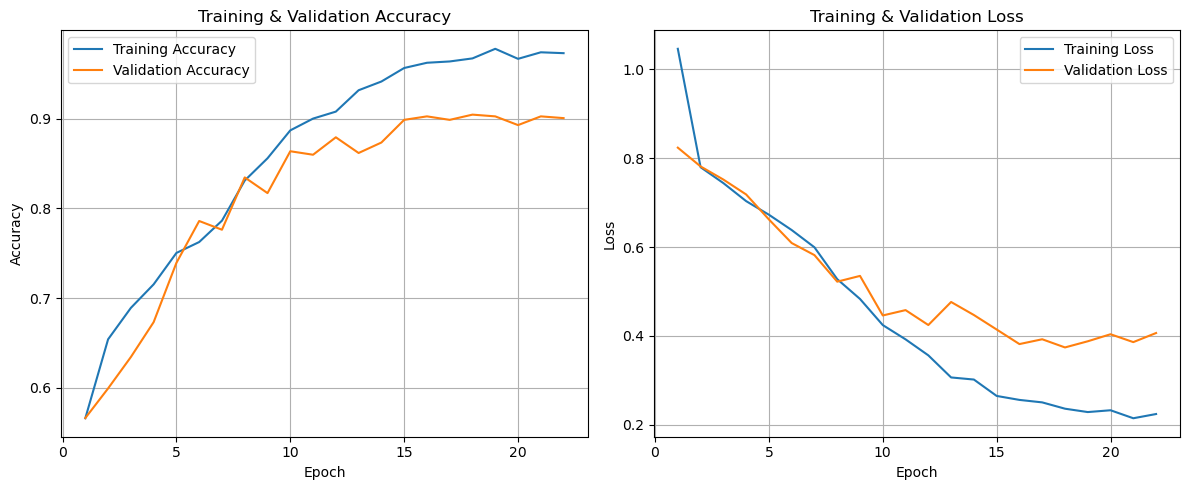

In [237]:
import matplotlib.pyplot as plt

# Extract accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [177]:
from sklearn.model_selection import train_test_split

# Assuming you already have X_baseline and y_baseline from extract_dataset_baseline
print("✅ Before splitting:", X_baseline.shape, y_baseline.shape)

X_baseline_train, X_baseline_test, y_baseline_train, y_baseline_test = train_test_split(
    X_baseline, y_baseline,
    test_size=0.2,
    random_state=42,
    stratify=y_baseline
)

print("✅ After splitting:")
print("Train Set:", X_baseline_train.shape, y_baseline_train.shape)
print("Test Set:", X_baseline_test.shape, y_baseline_test.shape)


✅ Before splitting: (12849, 65) (12849,)
✅ After splitting:
Train Set: (10279, 65) (10279,)
Test Set: (2570, 65) (2570,)


In [187]:
import itertools
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from time import time

param_grid = {
    'num_trees': [75, 100],
    'tree_depth': [5, 10],
    'min_split_count': [2, 5],
    'num_features': [None, 3]
}

param_combinations = list(itertools.product(
    param_grid['num_trees'],
    param_grid['tree_depth'],
    param_grid['min_split_count'],
    param_grid['num_features']
))

results = []

for i, (n_trees, depth, min_split, num_feats) in enumerate(param_combinations):
    print(f"\n🔍 Running config {i+1}/{len(param_combinations)}")
    print(f"Params: trees={n_trees}, depth={depth}, min_split={min_split}, num_feats={num_feats}")
    
    start = time()
    
    model = EnsembleForest(num_trees=n_trees,
                           tree_depth=depth,
                           min_split_count=min_split,
                           num_features=num_feats)
    
    model.fit(X_baseline_train, y_baseline_train.astype(int))
    y_pred = model.predict(X_baseline_test)
    
    acc = accuracy_score(y_baseline_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")
    print("📋 Classification Report:\n", classification_report(y_baseline_test, y_pred))
    print("🧩 Confusion Matrix:\n", confusion_matrix(y_baseline_test, y_pred))
    
    end = time()
    
    results.append({
        'num_trees': n_trees,
        'tree_depth': depth,
        'min_split_count': min_split,
        'num_features': num_feats if num_feats is not None else 'all',
        'accuracy': acc,
        'runtime_sec': round(end - start, 2)
    })

df_results = pd.DataFrame(results)
csv_path = "custom_forest_grid_results.csv"
df_results.to_csv(csv_path, index=False)
print(f"\n📄 Results saved to '{csv_path}'")



🔍 Running config 1/16
Params: trees=75, depth=5, min_split=2, num_feats=None
✅ Accuracy: 0.7911
📋 Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.72      0.77      1261
         1.0       0.76      0.86      0.81      1309

    accuracy                           0.79      2570
   macro avg       0.80      0.79      0.79      2570
weighted avg       0.80      0.79      0.79      2570

🧩 Confusion Matrix:
 [[ 908  353]
 [ 184 1125]]

🔍 Running config 2/16
Params: trees=75, depth=5, min_split=2, num_feats=3
✅ Accuracy: 0.7389
📋 Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.70      0.72      1261
         1.0       0.73      0.78      0.75      1309

    accuracy                           0.74      2570
   macro avg       0.74      0.74      0.74      2570
weighted avg       0.74      0.74      0.74      2570

🧩 Confusion Matrix:
 [[ 877  384]
 [ 287 1022]]

🔍 Runn

KeyboardInterrupt: 

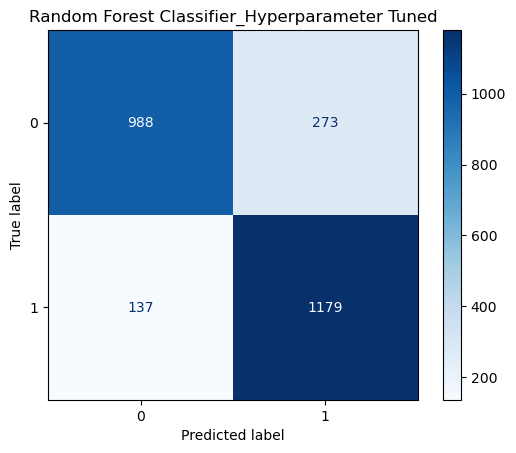

In [207]:
# Confusion matrix values for the first model
cm1 = np.array([[988, 273],
                [137, 1179]])

# Display the confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1)
disp1.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Classifier_Hyperparameter Tuned")
plt.show()

In [175]:
print("Full Dataset:", X_baseline.shape, y_baseline.shape)
print("Train Set:", X_baseline_train.shape, y_baseline_train.shape)
print("Test Set:", X_baseline_test.shape, y_baseline_test.shape)


Full Dataset: (12849, 65) (12849,)
Train Set: (100, 20) (100,)
Test Set: (30, 20) (30,)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:44:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.1, reg_lambda=1, subsample=1.0; total time=   3.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time=   2.1s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.05, max_depth=5, n_estimators=200, reg_alpha=0.1, reg_lambda=1.5, subsample=1.0; total time=   2.0s
[CV] END colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_depth=10, n_estimators=100, reg_alpha=0.1, reg_lambda=1.5, subsample=0.8; total time=   5.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_depth=7, n_estimators=300, reg_alpha=0.01, reg_lambda=0.5, subsample=0.8; total time=   6.0s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.05, 

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:45:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i,


Best Parameters: {'subsample': 0.6, 'reg_lambda': 1.5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.8}
Best CV Accuracy: 0.8977524685923107

✅ Test Accuracy: 0.8844
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      1261
           1       0.87      0.90      0.89      1309

    accuracy                           0.88      2570
   macro avg       0.89      0.88      0.88      2570
weighted avg       0.88      0.88      0.88      2570

🧩 Confusion Matrix:
 [[1090  171]
 [ 126 1183]]


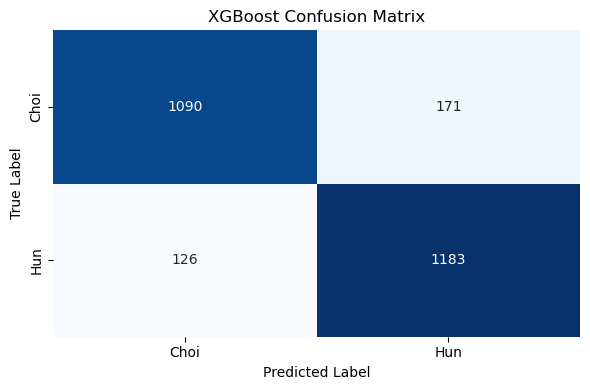

In [213]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ✅ Make sure your labels are integers
y_xgb_train = y_xgb_train.astype(int)
y_xgb_test = y_xgb_test.astype(int)

# ✅ 1. Define the XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# ✅ 2. Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3, 0.5],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0.5, 1, 1.5]
}

# ✅ 3. Randomized search
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# ✅ 4. Fit model
random_search.fit(X_xgb_train, y_xgb_train)

# ✅ 5. Best params and CV score
print("\nBest Parameters:", random_search.best_params_)
print("Best CV Accuracy:", random_search.best_score_)

# ✅ 6. Evaluate on test set
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_xgb_test)

print(f"\n✅ Test Accuracy: {accuracy_score(y_xgb_test, y_pred):.4f}")
print("📋 Classification Report:\n", classification_report(y_xgb_test, y_pred))

# ✅ 7. Confusion matrix
cm = confusion_matrix(y_xgb_test, y_pred)
print("🧩 Confusion Matrix:\n", cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Choi', 'Hun'], yticklabels=['Choi', 'Hun'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("XGBoost Confusion Matrix")
plt.tight_layout()
plt.show()
